In [1]:
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode


In [8]:
from improved_augmentation import enhanced_transforms

data_dir = '../datas'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train_organized'), enhanced_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'valid_organized'), enhanced_transforms['val']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test_organized'), enhanced_transforms['test'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Check for available accelerator (CUDA, MPS, etc.)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device")
print(f"\nDataset sizes:")
print(f"  Training: {dataset_sizes['train']}")
print(f"  Validation: {dataset_sizes['val']}")
print(f"  Test: {dataset_sizes['test']}")
print(f"\nNumber of classes: {len(class_names)}")
print(f"Classes: {class_names}")



Using cuda device

Dataset sizes:
  Training: 11499
  Validation: 1095
  Test: 546

Number of classes: 12
Classes: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


In [9]:
from collections import Counter
train_labels = [label for _, label in image_datasets['train'].imgs]
class_dist = Counter(train_labels)
print("Class distribution:", class_dist)

Class distribution: Counter({1: 1098, 9: 1079, 7: 1059, 6: 1044, 0: 1032, 10: 1008, 11: 960, 5: 942, 3: 909, 2: 857, 8: 797, 4: 714})


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    """Train the model with early stopping."""
    since = time.time()
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        best_epoch = 0
        
        # Training history
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                # Save history
                history[f'{phase}_loss'].append(epoch_loss)
                history[f'{phase}_acc'].append(epoch_acc.item())
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Deep copy the model if it's the best so far
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    torch.save(model.state_dict(), best_model_params_path)
            
            print()
            
            # Early stopping
            if epoch - best_epoch >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')
        
        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    
    return model, history


In [5]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Val Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Val Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_model(model, num_images=12):
    """Display predictions for a few images."""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\\nActual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def visualize_model_predictions(model, img_path):
    """Make prediction on a single custom image."""
    was_training = model.training
    model.eval()
    
    img = Image.open(img_path)
    img_tensor = data_transforms['val'](img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)
        
        plt.figure(figsize=(8, 6))
        plt.axis('off')
        plt.title(f'Predicted: {class_names[preds[0]]} (Confidence: {conf[0]:.2%})')
        imshow(img_tensor.cpu().data[0])
        plt.show()
        
        model.train(mode=was_training)


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader, dataset_name='Test'):
    """Evaluate model and display metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'{dataset_name} Accuracy: {accuracy:.4f}\\n')
    
    # Classification report
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_preds, all_labels


### ResNet18

In [56]:
# Load pretrained ResNet18
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Replace final fully connected layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # 12 classes

# # Replace final fully connected layer WITH DROPOUT
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Sequential(
#     nn.Dropout(0.4),  # ← Add dropout for regularization
#     nn.Linear(num_ftrs, len(class_names))
# )

model_ft = model_ft.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Optimizer - AdamW (better than SGD for transfer learning)
# optimizer_ft = optim.AdamW(
#     model_ft.parameters(), 
#     lr=0.0001,           # ← Lower LR for fine-tuning
#     weight_decay=0.01,   # ← Stronger regularization
#     betas=(0.9, 0.999)
# )

# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# # Learning rate scheduler - Cosine Annealing (smoother than StepLR)
# exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(
#     optimizer_ft, 
#     T_max=25,      # Total epochs
#     eta_min=1e-6   # Minimum LR
# )

print("Model architecture:")
print(f"Total parameters: {sum(p.numel() for p in model_ft.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_ft.parameters() if p.requires_grad):,}")


Model architecture:
Total parameters: 11,182,668
Trainable parameters: 11,182,668


In [57]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                    num_epochs=25, patience=5)


Epoch 0/24
----------
train Loss: 1.0913 Acc: 0.6706
val Loss: 0.5050 Acc: 0.8438

Epoch 1/24
----------
train Loss: 0.5917 Acc: 0.8124
val Loss: 0.4294 Acc: 0.8648

Epoch 2/24
----------
train Loss: 0.4818 Acc: 0.8479
val Loss: 0.3917 Acc: 0.8840

Epoch 3/24
----------
train Loss: 0.4161 Acc: 0.8675
val Loss: 0.4037 Acc: 0.8767

Epoch 4/24
----------
train Loss: 0.3686 Acc: 0.8799
val Loss: 0.4023 Acc: 0.8822

Epoch 5/24
----------
train Loss: 0.3234 Acc: 0.8935
val Loss: 0.3981 Acc: 0.8749

Epoch 6/24
----------
train Loss: 0.2892 Acc: 0.9081
val Loss: 0.4129 Acc: 0.8703

Epoch 7/24
----------
train Loss: 0.2536 Acc: 0.9206
val Loss: 0.3955 Acc: 0.8813

Early stopping triggered after 8 epochs
Training complete in 4m 27s
Best val Acc: 0.8840


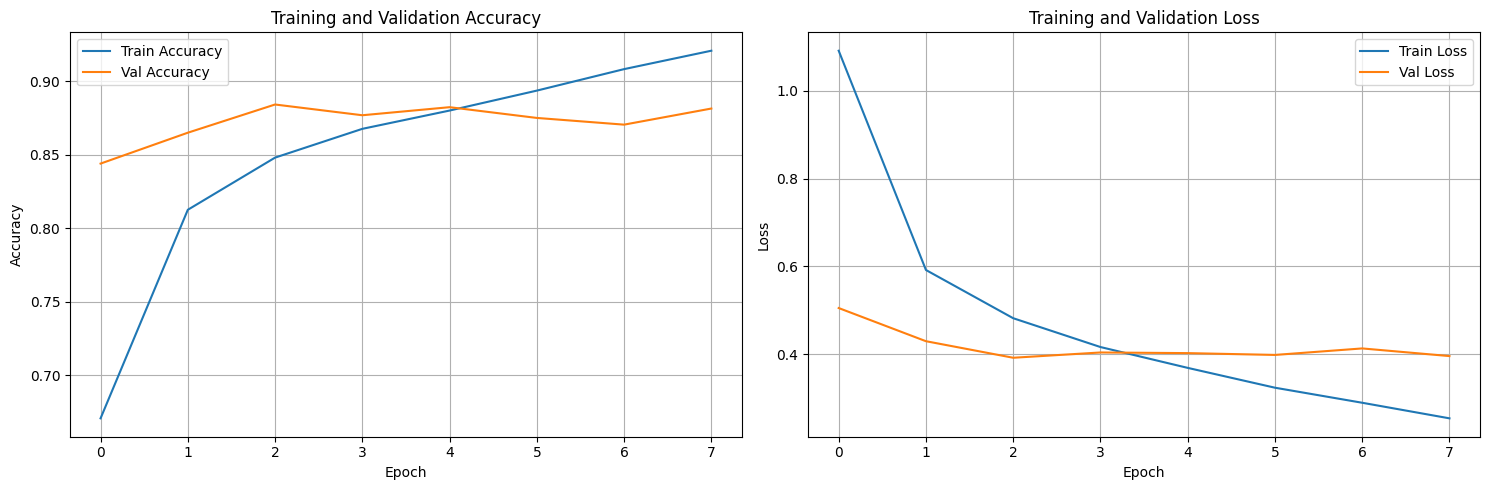

In [58]:
# Plot training history
plot_training_history(history_ft)


Test Accuracy: 0.8810\n
Classification Report:
              precision    recall  f1-score   support

        Ants       0.93      0.96      0.95        54
        Bees       0.88      0.93      0.90        40
     Beetles       0.83      0.59      0.69        41
Caterpillars       0.89      0.70      0.78        46
  Earthworms       0.73      0.81      0.77        27
     Earwigs       0.84      0.80      0.82        59
Grasshoppers       0.77      0.95      0.85        38
       Moths       1.00      0.96      0.98        47
       Slugs       0.82      0.87      0.84        46
      Snails       0.94      1.00      0.97        44
       Wasps       0.94      0.98      0.96        46
     Weevils       0.93      0.98      0.96        58

    accuracy                           0.88       546
   macro avg       0.87      0.88      0.87       546
weighted avg       0.88      0.88      0.88       546



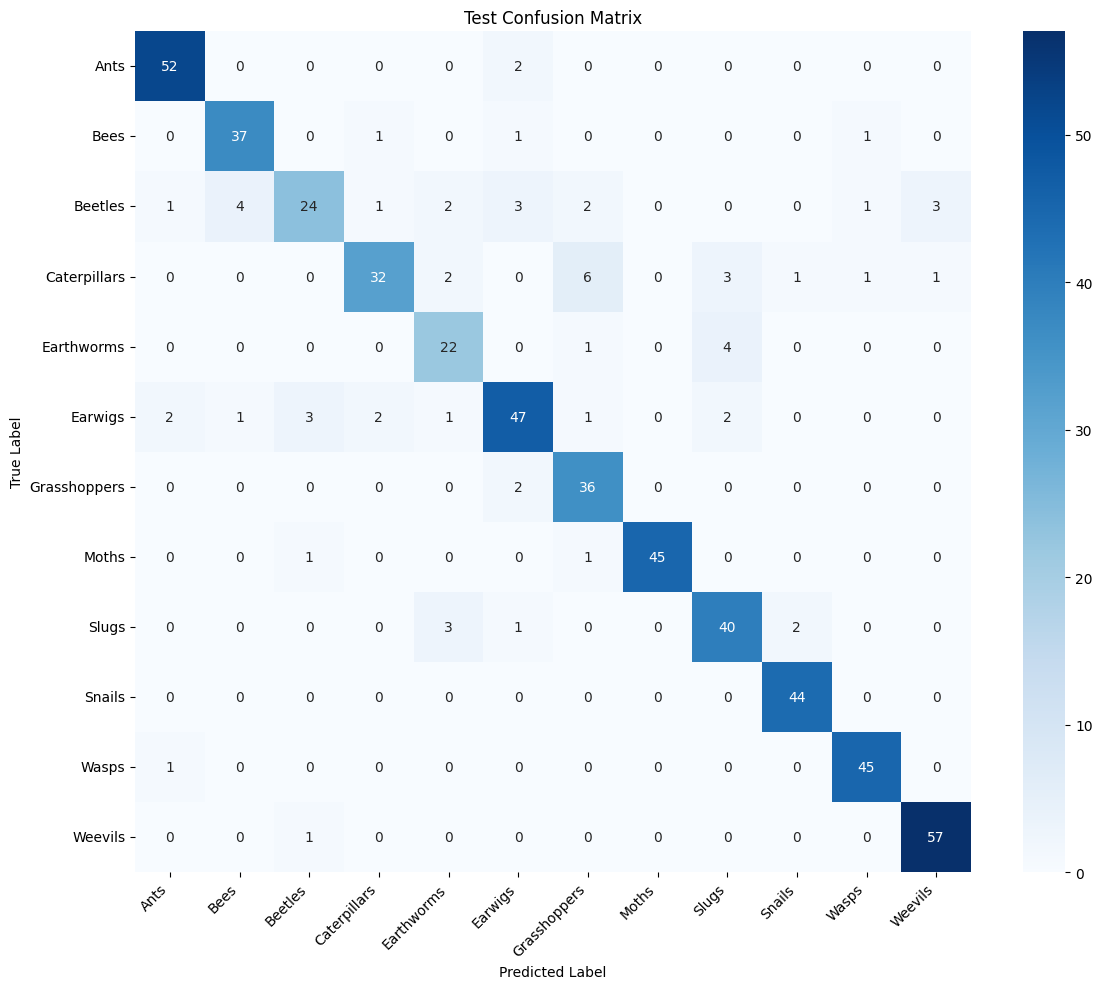

In [59]:
test_acc_ft, preds_ft, labels_ft = evaluate_model(model_ft, dataloaders['test'], 'Test')


In [66]:
# Save model
torch.save(model_ft.state_dict(), 'insect_classifier_finetuned.pth')
print("Model saved as 'insect_classifier_finetuned.pth'")

Model saved as 'insect_classifier_finetuned.pth'


### DenseNet121

In [ ]:
########without dropout########
# # Load pretrained DenseNet-121
# model_densenet = models.densenet121(weights='IMAGENET1K_V1')

# # Replace final classifier layer
# # DenseNet uses 'classifier' instead of 'fc'
# num_ftrs_dense = model_densenet.classifier.in_features
# model_densenet.classifier = nn.Linear(num_ftrs_dense, len(class_names))

# model_densenet = model_densenet.to(device)

# # Loss function
# criterion_dense = nn.CrossEntropyLoss()

# # # Adam optimizer works better for DenseNet (adaptive learning rates)
# # optimizer_densenet = optim.Adam(model_densenet.parameters(), lr=0.0001, weight_decay=1e-3)

# # Or use AdamW which handles weight decay better:
# optimizer_densenet = optim.AdamW(
#     model_densenet.parameters(), 
#     lr=0.0001, 
#     weight_decay=0.01  #  Stronger regularization
# )

###########################

##### with dropout#####
# Load pretrained DenseNet-121
model_densenet = models.densenet121(weights='IMAGENET1K_V1')

# Get input features
num_ftrs_dense = model_densenet.classifier.in_features

# Add dropout to classifier
model_densenet.classifier = nn.Sequential(
    nn.Dropout(0.4),  # Try 0.3-0.5 for your overfitting issue
    nn.Linear(num_ftrs_dense, len(class_names))
)

model_densenet = model_densenet.to(device)

# Use stronger weight decay too
criterion_dense = nn.CrossEntropyLoss(label_smoothing=0.1)  # Add label smoothing

# # Focal Loss
# from advanced_training_techniques import FocalLoss
# criterion_dense = FocalLoss(alpha=1, gamma=2)

optimizer_densenet = optim.AdamW(  # Use AdamW instead of Adam
    model_densenet.parameters(), 
    lr=0.0001, 
    weight_decay=0.01  # Increase from 1e-4
)

##########################

# Cosine annealing learning rate scheduler
scheduler_densenet = lr_scheduler.CosineAnnealingLR(optimizer_densenet, T_max=25, eta_min=1e-6)

print("DenseNet-121 Model Architecture:")
print(f"Total parameters: {sum(p.numel() for p in model_densenet.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_densenet.parameters() if p.requires_grad):,}")


DenseNet-121 Model Architecture:
Total parameters: 6,966,156
Trainable parameters: 6,966,156


In [61]:
model_densenet, history_densenet = train_model(model_densenet, criterion_dense, optimizer_densenet, 
                                                 scheduler_densenet, num_epochs=25, patience=5)




Epoch 0/24
----------
train Loss: 1.2394 Acc: 0.7328
val Loss: 0.8306 Acc: 0.8895

Epoch 1/24
----------
train Loss: 0.8740 Acc: 0.8693
val Loss: 0.8075 Acc: 0.9023

Epoch 2/24
----------
train Loss: 0.8002 Acc: 0.9047
val Loss: 0.8221 Acc: 0.8831

Epoch 3/24
----------
train Loss: 0.7503 Acc: 0.9280
val Loss: 0.8095 Acc: 0.8968

Epoch 4/24
----------
train Loss: 0.7195 Acc: 0.9376
val Loss: 0.8426 Acc: 0.8932

Epoch 5/24
----------
train Loss: 0.6924 Acc: 0.9488
val Loss: 0.7669 Acc: 0.9142

Epoch 6/24
----------
train Loss: 0.6807 Acc: 0.9516
val Loss: 0.7782 Acc: 0.9096

Epoch 7/24
----------
train Loss: 0.6554 Acc: 0.9629
val Loss: 0.7567 Acc: 0.9132

Epoch 8/24
----------
train Loss: 0.6457 Acc: 0.9638
val Loss: 0.8007 Acc: 0.9123

Epoch 9/24
----------
train Loss: 0.6366 Acc: 0.9687
val Loss: 0.7676 Acc: 0.9160

Epoch 10/24
----------
train Loss: 0.6256 Acc: 0.9728
val Loss: 0.7737 Acc: 0.9114

Epoch 11/24
----------
train Loss: 0.6121 Acc: 0.9794
val Loss: 0.7760 Acc: 0.9160

Ep

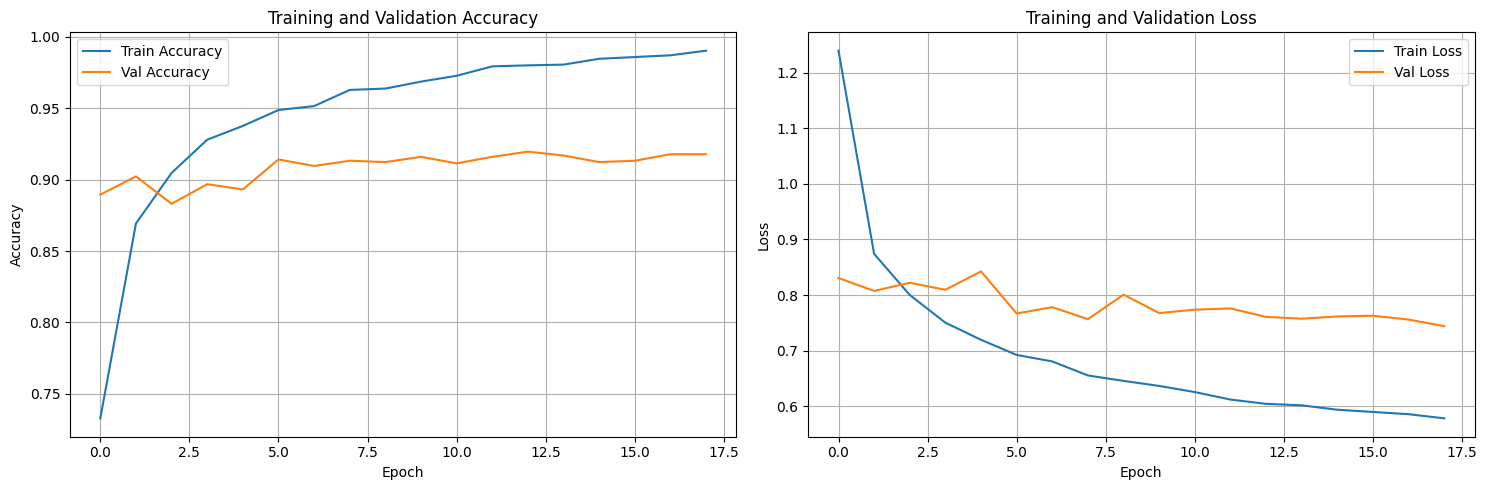

In [62]:
# Plot training history
plot_training_history(history_densenet)


Test Accuracy: 0.8993\n
Classification Report:
              precision    recall  f1-score   support

        Ants       0.91      0.98      0.95        54
        Bees       0.93      0.95      0.94        40
     Beetles       0.84      0.63      0.72        41
Caterpillars       0.80      0.72      0.76        46
  Earthworms       0.88      0.81      0.85        27
     Earwigs       0.87      0.88      0.87        59
Grasshoppers       0.82      0.95      0.88        38
       Moths       0.96      0.98      0.97        47
       Slugs       0.86      0.83      0.84        46
      Snails       0.92      1.00      0.96        44
       Wasps       0.98      1.00      0.99        46
     Weevils       0.97      0.98      0.97        58

    accuracy                           0.90       546
   macro avg       0.89      0.89      0.89       546
weighted avg       0.90      0.90      0.90       546



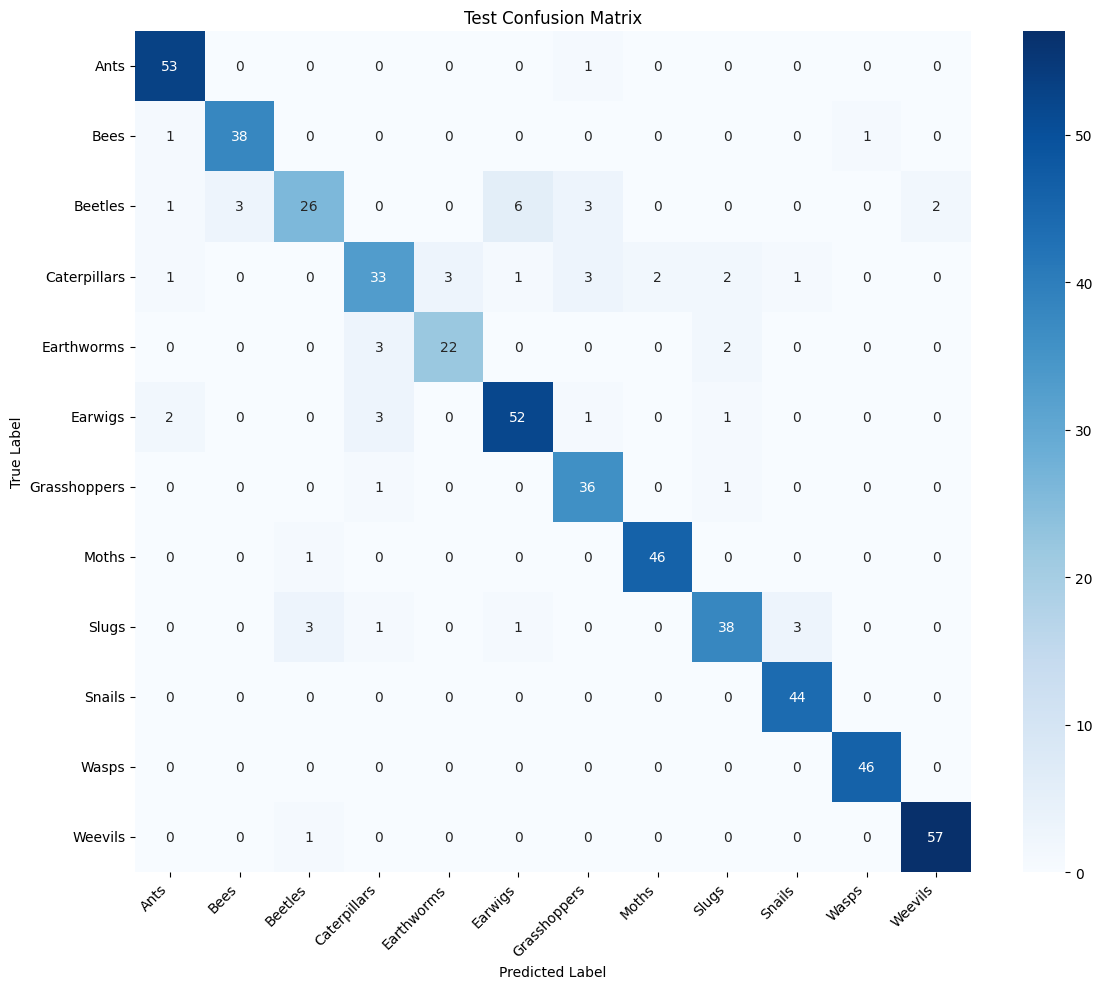

In [64]:
test_acc_densenet, preds_densenet, labels_densenet = evaluate_model(model_densenet, dataloaders['test'], 'Test')


In [65]:
# Save model
torch.save(model_densenet.state_dict(), 'insect_classifier_densenet121.pth')
print("Model saved as 'insect_classifier_densenet121.pth'")


Model saved as 'insect_classifier_densenet121.pth'


### EffcientNet-V2-S

In [ ]:
# Load pretrained EfficientNet-V2-S
model_efficientnet = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# Replace final classifier layer
# EfficientNet uses a classifier with multiple layers
num_ftrs_eff = model_efficientnet.classifier[1].in_features
model_efficientnet.classifier[1] = nn.Linear(num_ftrs_eff, len(class_names))

# # Replace final classifier layer WITH DROPOUT
# num_ftrs_eff = model_efficientnet.classifier[1].in_features
# model_efficientnet.classifier[1] = nn.Sequential(
#     nn.Dropout(0.5),  # ← Add stronger dropout
#     nn.Linear(num_ftrs_eff, len(class_names))
# )

model_efficientnet = model_efficientnet.to(device)

# Loss function with label smoothing for better generalization
criterion_eff = nn.CrossEntropyLoss(label_smoothing=0.1)

# AdamW optimizer (Adam with decoupled weight decay)
optimizer_efficientnet = optim.AdamW(model_efficientnet.parameters(), 
                                      lr=0.0001, 
                                      weight_decay=0.01,
                                      betas=(0.9, 0.999))

# # Cosine annealing with warm restarts
# scheduler_efficientnet = lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer_efficientnet, 
#     T_0=10,  # Restart every 10 epochs
#     T_mult=1,
#     eta_min=1e-6
# )

# NEW (more stable):
scheduler_efficientnet = lr_scheduler.CosineAnnealingLR(
    optimizer_efficientnet, T_max=25, eta_min=1e-6
)

print("EfficientNet-V2-S Model Architecture:")
print(f"Total parameters: {sum(p.numel() for p in model_efficientnet.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_efficientnet.parameters() if p.requires_grad):,}")


EfficientNet-V2-S Model Architecture:
Total parameters: 20,192,860
Trainable parameters: 20,192,860


In [8]:
model_efficientnet, history_efficientnet = train_model(model_efficientnet, criterion_eff, 
                                                        optimizer_efficientnet, scheduler_efficientnet, 
                                                        num_epochs=25, patience=5)


Epoch 0/24
----------
train Loss: 1.1483 Acc: 0.7608
val Loss: 0.6968 Acc: 0.9397

Epoch 1/24
----------
train Loss: 0.7260 Acc: 0.9315
val Loss: 0.6897 Acc: 0.9416

Epoch 2/24
----------
train Loss: 0.6634 Acc: 0.9545
val Loss: 0.6818 Acc: 0.9425

Epoch 3/24
----------
train Loss: 0.6261 Acc: 0.9675
val Loss: 0.6829 Acc: 0.9425

Epoch 4/24
----------
train Loss: 0.6072 Acc: 0.9740
val Loss: 0.6969 Acc: 0.9370

Epoch 5/24
----------
train Loss: 0.5951 Acc: 0.9793
val Loss: 0.6965 Acc: 0.9416

Epoch 6/24
----------
train Loss: 0.5874 Acc: 0.9808
val Loss: 0.6877 Acc: 0.9470

Epoch 7/24
----------
train Loss: 0.5777 Acc: 0.9845
val Loss: 0.7011 Acc: 0.9443

Epoch 8/24
----------
train Loss: 0.5769 Acc: 0.9844
val Loss: 0.7076 Acc: 0.9397

Epoch 9/24
----------
train Loss: 0.5674 Acc: 0.9886
val Loss: 0.7075 Acc: 0.9397

Epoch 10/24
----------
train Loss: 0.5704 Acc: 0.9873
val Loss: 0.7199 Acc: 0.9370

Epoch 11/24
----------
train Loss: 0.5632 Acc: 0.9900
val Loss: 0.6920 Acc: 0.9406

Ea

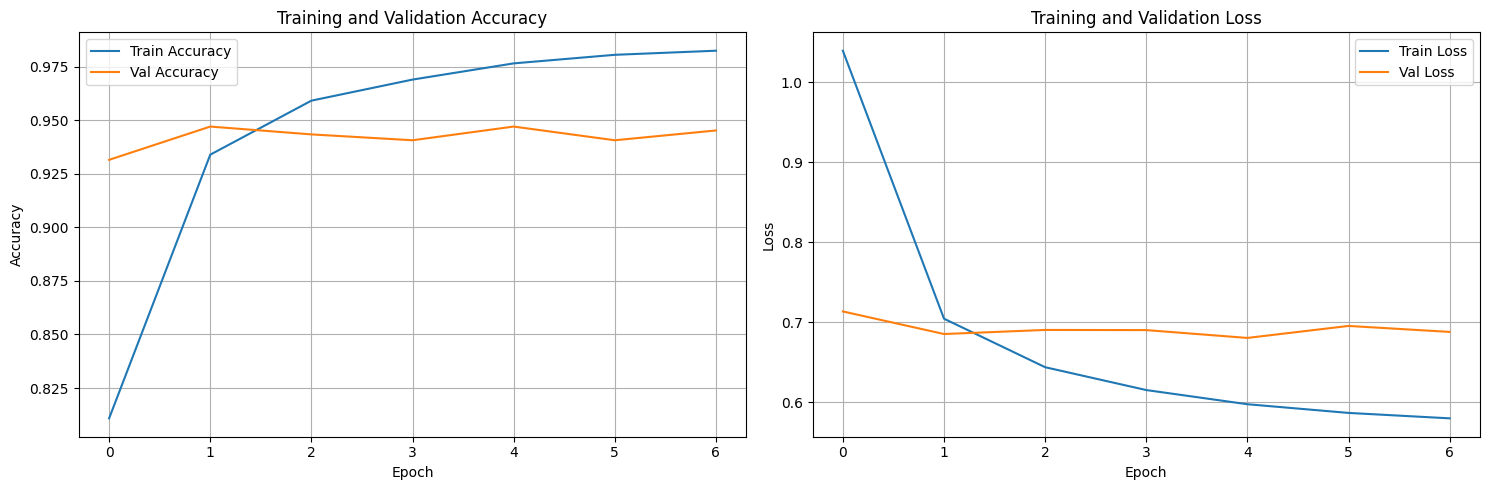

In [9]:
# Plot training history
plot_training_history(history_efficientnet)


Test Accuracy: 0.9286\n
Classification Report:
              precision    recall  f1-score   support

        Ants       0.98      0.98      0.98        54
        Bees       0.90      0.93      0.91        40
     Beetles       0.79      0.73      0.76        41
Caterpillars       0.85      0.87      0.86        46
  Earthworms       0.89      0.89      0.89        27
     Earwigs       0.96      0.93      0.95        59
Grasshoppers       0.84      0.97      0.90        38
       Moths       1.00      0.94      0.97        47
       Slugs       0.96      0.93      0.95        46
      Snails       0.98      1.00      0.99        44
       Wasps       0.94      1.00      0.97        46
     Weevils       0.98      0.93      0.96        58

    accuracy                           0.93       546
   macro avg       0.92      0.93      0.92       546
weighted avg       0.93      0.93      0.93       546



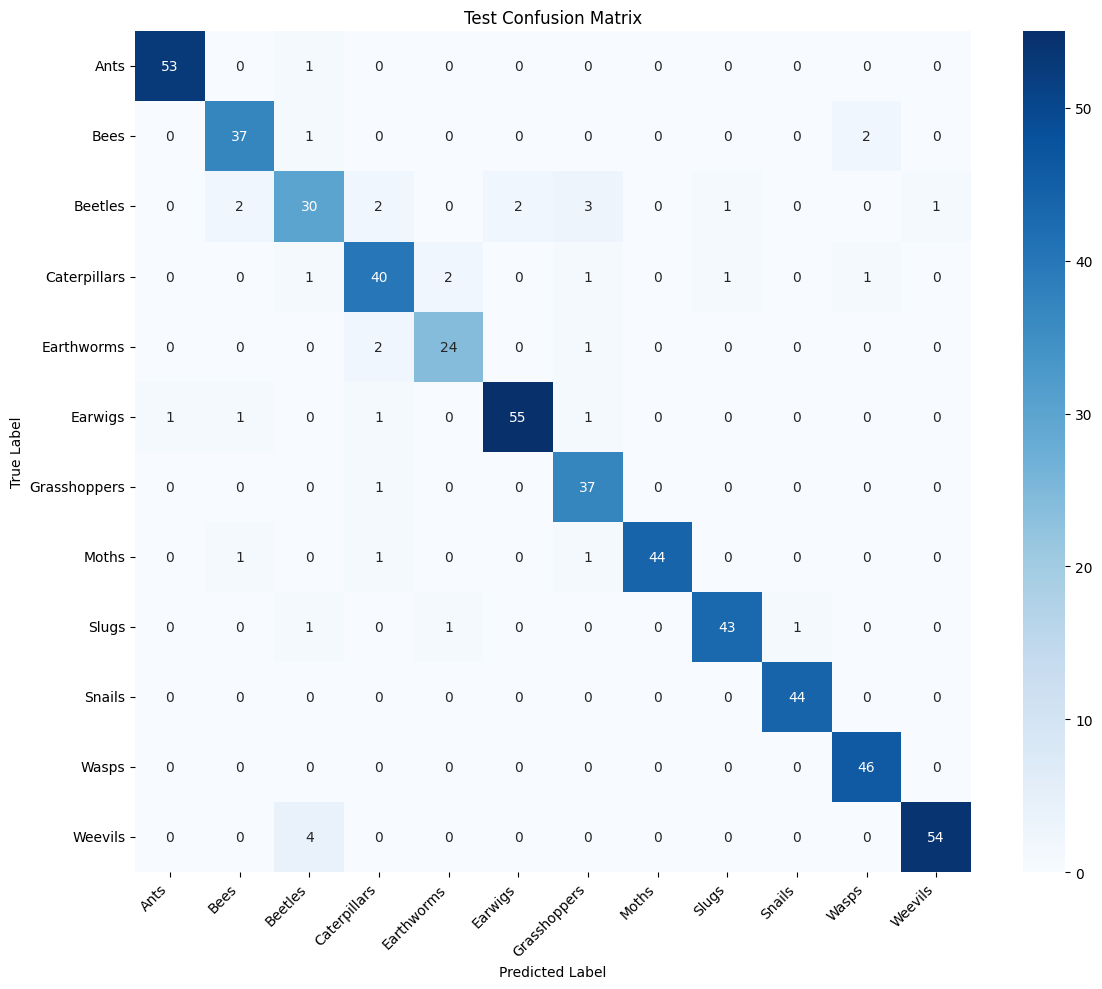

In [9]:
test_acc_efficientnet, preds_efficientnet, labels_efficientnet = evaluate_model(model_efficientnet, dataloaders['test'], 'Test')


In [11]:
# Save model
torch.save(model_efficientnet.state_dict(), 'insect_classifier_efficientnet_v2_s.pth')
print("Model saved as 'insect_classifier_efficientnet_v2_s.pth'")


Model saved as 'insect_classifier_efficientnet_v2_s.pth'


### Ensemble Method

In [1]:
import torch
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt

# Import regular, ensemble and TTA functions
from ensemble_utils import (
    load_models,
    evaluate_single_model,
    evaluate_single_model_with_tta,
    evaluate_ensemble,
    evaluate_ensemble_with_tta,
    compare_results
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

# Load test data
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder('../datas/test_organized', test_transforms)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=0
)

num_classes = len(test_dataset.classes)
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {num_classes}")

Using device: cuda:0

Test samples: 546
Classes: 12


In [2]:
# Load all models
models = load_models(num_classes=num_classes, model_dir='../models/',device=device)

model_resnet = models['resnet']
model_densenet = models['densenet']
model_efficientnet = models['efficientnet']

models_list = [model_resnet, model_densenet, model_efficientnet]

Loading ResNet-18 from ../models/insect_classifier_finetuned.pth...
✓ ResNet-18 loaded
Loading DenseNet-121 from ../models/insect_classifier_densenet121.pth...
✓ DenseNet-121 loaded
Loading EfficientNet-V2-S from ../models/insect_classifier_efficientnet_v2_s.pth...
✓ EfficientNet-V2-S loaded

✓ Loaded 3 models successfully!


In [3]:
# Do the comparison
print("="*80)
print("COMPLETE COMPARISON: Regular vs TTA vs Ensemble vs TTA+Ensemble")
print("="*80)

# ========================================
# 1. Individual Models (No TTA)
# ========================================
print("\n1️⃣  INDIVIDUAL MODELS (Standard)")
print("-"*80)
acc_resnet = evaluate_single_model(model_resnet, test_loader, "ResNet-18", device)
acc_densenet = evaluate_single_model(model_densenet, test_loader, "DenseNet-121", device)
acc_efficientnet = evaluate_single_model(model_efficientnet, test_loader, "EfficientNet-V2-S", device)

# ========================================
# 2. Individual Models (With TTA)
# ========================================
print("\n2️⃣  INDIVIDUAL MODELS + TTA")
print("-"*80)
acc_resnet_tta = evaluate_single_model_with_tta(
    model_resnet, test_loader, n_augmentations=4, model_name="ResNet-18", device=device
)
acc_densenet_tta = evaluate_single_model_with_tta(
    model_densenet, test_loader, n_augmentations=4, model_name="DenseNet-121", device=device
)
acc_efficientnet_tta = evaluate_single_model_with_tta(
    model_efficientnet, test_loader, n_augmentations=4, model_name="EfficientNet-V2-S", device=device
)

# ========================================
# 3. Ensemble (No TTA)
# ========================================
print("\n3️⃣  ENSEMBLE METHODS (Standard)")
print("-"*80)

# Equal weights
acc_ensemble_equal, _, _ = evaluate_ensemble(
    models_list, test_loader, weights=None, 
    ensemble_name="Ensemble (Equal)", device=device
)

# Weighted (favor better models)
weights = [0.15, 0.35, 0.50]  # ResNet, DenseNet, EfficientNet
acc_ensemble_weighted, _, _ = evaluate_ensemble(
    models_list, test_loader, weights=weights,
    ensemble_name="Ensemble (Weighted)", device=device
)

# ========================================
# 4. Ensemble + TTA (ULTIMATE!)
# ========================================
print("\n4️⃣  ENSEMBLE + TTA (Ultimate Combination)")
print("-"*80)

# Equal weights + TTA
acc_ensemble_tta_equal, _, _ = evaluate_ensemble_with_tta(
    models_list, test_loader, n_augmentations=4, weights=None,
    ensemble_name="Ensemble (Equal) + TTA", device=device
)

# Weighted + TTA
acc_ensemble_tta_weighted, _, _ = evaluate_ensemble_with_tta(
    models_list, test_loader, n_augmentations=4, weights=weights,
    ensemble_name="Ensemble (Weighted) + TTA", device=device
)

print("\n" + "="*80)

COMPLETE COMPARISON: Regular vs TTA vs Ensemble vs TTA+Ensemble

1️⃣  INDIVIDUAL MODELS (Standard)
--------------------------------------------------------------------------------
ResNet-18                      Accuracy: 0.8810 (88.10%)
DenseNet-121                   Accuracy: 0.8993 (89.93%)
EfficientNet-V2-S              Accuracy: 0.9304 (93.04%)

2️⃣  INDIVIDUAL MODELS + TTA
--------------------------------------------------------------------------------
ResNet-18                      Accuracy (TTA): 0.8718 (87.18%)
DenseNet-121                   Accuracy (TTA): 0.9084 (90.84%)
EfficientNet-V2-S              Accuracy (TTA): 0.9377 (93.77%)

3️⃣  ENSEMBLE METHODS (Standard)
--------------------------------------------------------------------------------
Ensemble (Equal)               Accuracy: 0.9304 (93.04%)
Ensemble (Weighted)            Accuracy: 0.9396 (93.96%)

4️⃣  ENSEMBLE + TTA (Ultimate Combination)
----------------------------------------------------------------------------

In [12]:
# Compile all results
results = {
    # Individual models
    'ResNet-18': acc_resnet,
    'DenseNet-121': acc_densenet,
    'EfficientNet-V2-S': acc_efficientnet,
    
    # Individual + TTA
    'ResNet-18 + TTA': acc_resnet_tta,
    'DenseNet-121 + TTA': acc_densenet_tta,
    'EfficientNet-V2-S + TTA': acc_efficientnet_tta,
    
    # Ensemble
    'Ensemble (Equal)': acc_ensemble_equal,
    'Ensemble (Weighted)': acc_ensemble_weighted,
    
    # Ensemble + TTA
    'Ensemble (Equal) + TTA': acc_ensemble_tta_equal,
    'Ensemble (Weighted) + TTA': acc_ensemble_tta_weighted,
}

# Create DataFrame
df = pd.DataFrame([
    {'Method': k, 'Accuracy': v, 'Percentage': f'{v*100:.2f}%'} 
    for k, v in results.items()
])
df = df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("FINAL RESULTS (Sorted by Accuracy)")
print("="*80)
display(df)

# Find best
best_method = df.iloc[0]['Method']
best_acc = df.iloc[0]['Accuracy']
baseline_acc = acc_efficientnet  # Best single model

print(f"\n🏆 Best Method: {best_method}")
print(f"✨ Best Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"📈 Improvement over baseline: +{(best_acc - baseline_acc)*100:.2f}%")


FINAL RESULTS (Sorted by Accuracy)


,Method,Accuracy,Percentage
0,Ensemble (Weighted) + TTA,0.941392,94.14%
1,Ensemble (Weighted),0.939560,93.96%
2,EfficientNet-V2-S + TTA,0.937729,93.77%
3,Ensemble (Equal) + TTA,0.934066,93.41%
4,EfficientNet-V2-S,0.930403,93.04%
5,Ensemble (Equal),0.930403,93.04%
6,DenseNet-121 + TTA,0.908425,90.84%
7,DenseNet-121,0.899267,89.93%
8,ResNet-18,0.880952,88.10%
9,ResNet-18 + TTA,0.871795,87.18%



🏆 Best Method: Ensemble (Weighted) + TTA
✨ Best Accuracy: 0.9414 (94.14%)
📈 Improvement over baseline: +1.10%


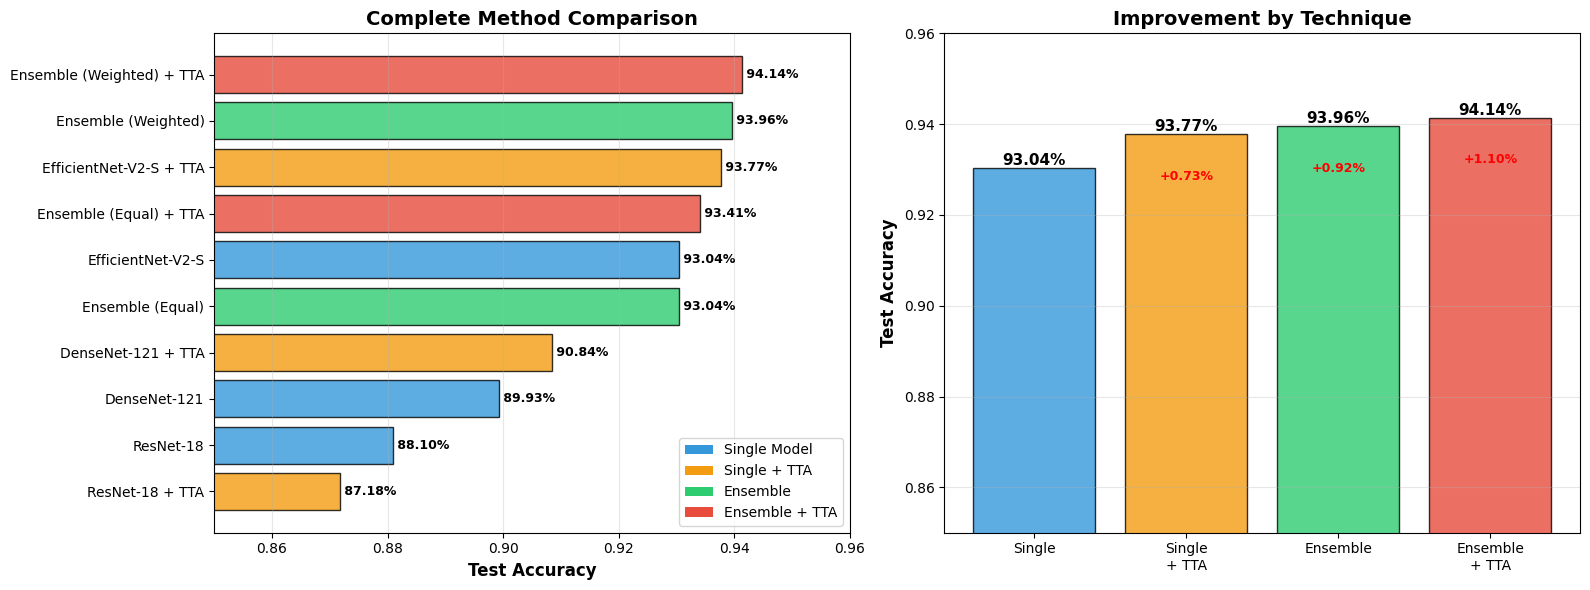

✅ Figure saved as 'tta_ensemble_comparison.png'


In [13]:
# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ===== Left Plot: All Methods =====
methods = df['Method'].tolist()
accuracies = df['Accuracy'].tolist()

colors = []
for method in methods:
    if 'TTA' in method and 'Ensemble' in method:
        colors.append('#e74c3c')  # Red for TTA+Ensemble
    elif 'Ensemble' in method:
        colors.append('#2ecc71')  # Green for Ensemble
    elif 'TTA' in method:
        colors.append('#f39c12')  # Orange for TTA
    else:
        colors.append('#3498db')  # Blue for standard

bars = ax1.barh(range(len(methods)), accuracies, color=colors, alpha=0.8, edgecolor='black')

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2,
             f' {acc*100:.2f}%',
             ha='left', va='center', fontweight='bold', fontsize=9)

ax1.set_yticks(range(len(methods)))
ax1.set_yticklabels(methods, fontsize=10)
ax1.set_xlabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Complete Method Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim([0.85, 0.96])
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()  # Best at top

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Single Model'),
    Patch(facecolor='#f39c12', label='Single + TTA'),
    Patch(facecolor='#2ecc71', label='Ensemble'),
    Patch(facecolor='#e74c3c', label='Ensemble + TTA')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)

# ===== Right Plot: Improvement Analysis =====
categories = ['Single', 'Single\n+ TTA', 'Ensemble', 'Ensemble\n+ TTA']
category_scores = [
    max(acc_resnet, acc_densenet, acc_efficientnet),
    max(acc_resnet_tta, acc_densenet_tta, acc_efficientnet_tta),
    max(acc_ensemble_equal, acc_ensemble_weighted),
    max(acc_ensemble_tta_equal, acc_ensemble_tta_weighted)
]
category_colors = ['#3498db', '#f39c12', '#2ecc71', '#e74c3c']

bars2 = ax2.bar(categories, category_scores, color=category_colors, alpha=0.8, edgecolor='black')

# Add value labels
for bar, score in zip(bars2, category_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{score*100:.2f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add improvement annotations
baseline = category_scores[0]
for i, score in enumerate(category_scores[1:], 1):
    improvement = (score - baseline) * 100
    ax2.annotate(f'+{improvement:.2f}%',
                xy=(i, score - 0.01),
                fontsize=9, ha='center', color='red', fontweight='bold')

ax2.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Improvement by Technique', fontsize=14, fontweight='bold')
ax2.set_ylim([0.85, 0.96])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('tta_ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved as 'tta_ensemble_comparison.png'")